# Object Modelling


### I. Imports

In [1]:
# making scene copies
from copy import deepcopy as dc
# math
import numpy as np
# ml
import torch as pt
# point cloud
import pytorch3d as pt3d
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
# physics
import warp as wp
import warp.sim as wps
# graphics
import drjit as dr
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as mit
# visual
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
# export
import os
import cv2

# setup
wp.init()
mi.set_variant('llvm_ad_rgb')

Warp 0.10.1 initialized:
   CUDA Toolkit: 11.5, Driver: 11.4
   Devices:
     "cpu"    | x86_64
     "cuda:0" | NVIDIA GeForce GTX 1050 Ti with Max-Q Design (sm_61)
   Kernel cache: /home/jonathan/.cache/warp/0.10.1


### II. Direct Trajectory Optimization 

#### Setup

In [2]:

#########
# Scene #
#########

# camera positioned to view the scene, adjust as needed
cam_pos = np.array([0.0, 1.0, 5.0])  
cam_target = np.array([0.0, 1.0, 0.0])
cam_up = np.array([0.0, 1.0, 0.0])

# ground
ground = True

# particle
particle_init_pos = np.array([-0.5, 1.0, 0.0])
particle_init_vel = np.array([5.0, -5.0, 0.0])
particle_radius = 0.2
particle_mass = 1.0

# wall
wall_pos = np.array([2.0, 1.0, 0.0])
wall_extents = np.array([0.25, 1.0, 1.0])
wall_rgb = np.array([0.7, 0.25, 0.2])

# target
target_pos = np.array([-2.0, 1.5, 0.0])
target_extents = 0.1 * np.ones(3)
target_rgb = np.array([0.2, 0.25, 0.7])

# contact parameters
ke = 1.0e4
kf = 0.0
kd = 1.0e1
mu = 0.2
rt = 1.0
margin = 10.0


##############
# Simulation #
##############

sim_duration = 0.6
# control frequency
fps = 60
frame_dt = 1.0 / float(fps)
frame_steps = int(sim_duration / frame_dt)
# sim frequency
sim_substeps = 8
sim_steps = frame_steps * sim_substeps
sim_dt = frame_dt / sim_substeps


def build_sim():
    device = wp.get_cuda_devices()[0]

    builder = wps.ModelBuilder()
    # particle
    builder.add_particle(pos=particle_init_pos, vel=particle_init_vel, radius=particle_radius, mass=particle_mass)
    # wall
    builder.add_shape_box(body=-1, 
                          pos=wall_pos, 
                          hx=wall_extents[0], hy=wall_extents[1], hz=wall_extents[2], 
                          ke=ke, kf=kf, kd=kd, mu=mu)
    model = builder.finalize(device)

    model.ground = ground
    model.soft_contact_ke = ke
    model.soft_contact_kf = kf
    model.soft_contact_kd = kd
    model.soft_contact_mu = mu
    model.soft_contact_margin = margin
    model.soft_contact_restitution = rt

    integrator = wp.sim.SemiImplicitIntegrator()

    # allocate sim states for trajectory
    states = [model.state(requires_grad=True) for _ in range(sim_steps + 1)]

    # one-shot contact creation
    wp.sim.collide(model, states[0])

    return device, integrator, model, states


def get_trajectory(states):
    trajectory = []
    for state in states[::sim_substeps]:
        trajectory.append(state.particle_q.numpy().squeeze())
    return np.array(trajectory)


#############
# Rendering #
#############

img_width = 128
img_height = 128
fov = 60

render_integrator = {
    'type': 'direct_reparam',
}

direct_traj_scene_dict = {
    'type': 'scene',
    'integrator': render_integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': mit.look_at(
                        origin=cam_pos,
                        target=cam_target,
                        up=cam_up),
        'fov': fov,
        'film': {
            'type': 'hdrfilm',
            'width': img_width,
            'height': img_height,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    "light": {
        "type": "constant"
    },
    'particle': {
        'type': 'sphere',
        'center': particle_init_pos,
        'radius': particle_radius,
        'bsdf': {'type': 'diffuse'}
    },
    'wall': {
        'type': 'cube',
        'to_world': mit.translate(wall_pos).scale(wall_extents),
        'bsdf' : {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': wall_rgb
            }
        }
    },
}


def render(scene_dict, states):
    imgs = []
    for state in states[::sim_substeps]:
        # update scene with current state
        scene_dict['particle']['center'] = state.particle_q.numpy().squeeze()
        scene = mi.load_dict(scene_dict)
        # render the image
        img = mi.render(scene)
        imgs.append(img)
    return imgs


def make_video(imgs, width, height, fps=60, output_folder="output", video_name="scene.mp4"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # assume all images are the same size
    video_fp = os.path.join(output_folder, video_name)
    video = cv2.VideoWriter(video_fp, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for img in imgs:
        bitmap = cv2.cvtColor(np.array(mi.util.convert_to_bitmap(img)), cv2.COLOR_RGB2BGR)
        video.write(bitmap)

    cv2.destroyAllWindows()
    video.release()



################
# Optimization #
################

@wp.kernel
def direct_loss_kernel(pos: wp.array(dtype=wp.vec3), target: wp.vec3, loss: wp.array(dtype=float)):
    # distance to target
    delta = pos[0] - target
    loss[0] = wp.dot(delta, delta)

@wp.kernel
def direct_step_kernel(x: wp.array(dtype=wp.vec3), grad: wp.array(dtype=wp.vec3), alpha: float):
    tid = wp.tid()

    # gradient descent step
    x[tid] = x[tid] - grad[tid] * alpha

def direct_compute_loss(device, model, integrator, states, loss):
    # run control loop
    for i in range(sim_steps):
        states[i].clear_forces()

        integrator.simulate(model, states[i], states[i + 1], sim_dt)

    # compute loss on final state
    wp.launch(direct_loss_kernel, dim=1, inputs=[states[-1].particle_q, target_pos, loss], device=device)

def direct_build_optim(device, model, integrator, states):
    # capture forward/backward passes
    loss = wp.zeros(1, dtype=wp.float32, device=device, requires_grad=True)

    wp.capture_begin()
    tape = wp.Tape()
    with tape:
        direct_compute_loss(device, model, integrator, states, loss)
    tape.backward(loss)
    graph = wp.capture_end()

    return graph, tape, loss

def direct_run_sim(graph, tape):
    with wp.ScopedTimer("Run", print=False):
        # forward + backward
        wp.capture_launch(graph)

        # clear grads for next iteration
        tape.zero()

def direct_optim_params(device, states, graph, tape, train_rate):
    with wp.ScopedTimer("Step", print=False):
        # forward + backward
        wp.capture_launch(graph)

        # gradient descent step
        x = states[0].particle_qd
        wp.launch(direct_step_kernel, dim=len(x), inputs=[x, x.grad, train_rate], device=device)

        # clear grads for next iteration
        tape.zero()

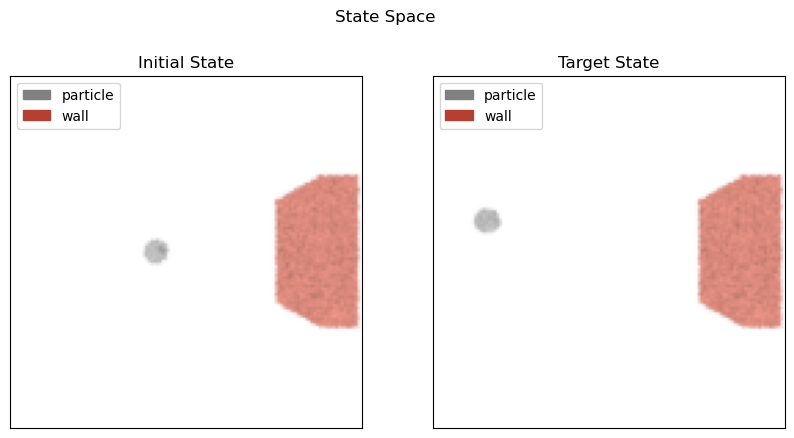

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('State Space')


##########
# States #
##########


legend_state = [
    mpatches.Patch(color='gray', label='particle'),
    mpatches.Patch(color=wall_rgb, label='wall')
]

init_scene_dict = dict(direct_traj_scene_dict)
init_scene_dict['particle']['center'] = dc(particle_init_pos)
bitmap_init = mi.util.convert_to_bitmap( mi.render(mi.load_dict(init_scene_dict)))
axs[0].imshow(bitmap_init)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend(handles=legend_state, loc='upper left')
axs[0].set_title('Initial State')

target_scene_dict = dict(direct_traj_scene_dict)
target_scene_dict['particle']['center'] = dc(target_pos)
bitmap_target = mi.util.convert_to_bitmap(mi.render(mi.load_dict(target_scene_dict)))
axs[1].imshow(bitmap_target)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend(handles=legend_state, loc='upper left')
axs[1].set_title('Target State')

plt.show()

In [ ]:
sampl

#### Optimization

In [ ]:
train_iters = 250
train_rate = 0.02
train_save_interval = 50

sim_device, phys_integrator, model, states = build_sim()
graph, tape, img_loss = direct_build_optim(sim_device, model, phys_integrator, states)
# initial run to set init trajectory and loss.
direct_run_sim(graph, tape)

vel_trajs = [get_trajectory(states)]
vel_losses = [img_loss.numpy()[0]]
for i in range(train_iters):
    direct_optim_params(sim_device, states, graph, tape, train_rate)
    vel_losses.append(img_loss.numpy()[0])

    # render examples
    #if (i == 0) or (i == train_iters - 1):
    #    imgs = render(scene_dict=direct_traj_scene_dict, states=states)
    #    make_video(imgs, img_width, img_height, fps, output_folder="output", video_name=f"direct_traj_iter_{i}.mp4")

    if (i+1) % train_save_interval == 0:
        print("Iteration: {}, Loss: {}".format(i+1, vel_losses[-1]))
        vel_trajs.append(get_trajectory(states))

#### Result

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Direct Trajectory Optimization')

################
# Trajectories #
################

axs[0].set_title('Trajectories') 
for i, vel_traj in enumerate(vel_trajs):
    axs[0].plot(vel_traj[:, 0], vel_traj[:, 1], label=f'iter {i*train_save_interval}')
axs[0].scatter(particle_init_pos[0], particle_init_pos[1], label='start', facecolors='none', edgecolors='black', s=50)
axs[0].scatter(target_pos[0], target_pos[1], color='black', label='target', marker='+', s=50)
axs[0].set_xlim([-2.1, 2.1])
axs[0].set_ylim([0.0, 2.0])
axs[0].set_xlabel('x');
axs[0].set_ylabel('y');
axs[0].legend(loc='lower left' )


##########
# Losses #
##########

axs[1].plot(vel_losses)
axs[1].set_xlabel('Iteration'); 
axs[1].set_ylabel('Loss'); 
axs[1].set_title('Loss per Iteration')

plt.show()

### III. Image-based Pose Optimization

#### Setup

In [ ]:
#########
# Scene #
#########

particle_radius = 0.2

#############
# Rendering #
#############

img_width = 128
img_height = 128
fov = 60

render_integrator = {
    'type': 'direct_reparam',
}

img_scene_dict = {
    'type': 'scene',
    'integrator': render_integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': mit.look_at(
                        origin=cam_pos,
                        target=cam_target,
                        up=cam_up),
        'fov': fov,
        'film': {
            'type': 'hdrfilm',
            'width': img_width,
            'height': img_height,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    "light": {
        "type": "constant"
    },
    'particle': {
        'type': 'sphere',
        'center': particle_init_pos,
        'radius': particle_radius,
        'bsdf': {'type': 'diffuse'}
    }
}


init_scene_dict = dict(img_scene_dict)
init_scene_dict['particle']['center'] = dc(particle_init_pos)
img_init = mi.render(mi.load_dict(init_scene_dict))

target_scene_dict = dict(img_scene_dict)
target_scene_dict['particle']['center'] = dc(target_pos)
img_ref = mi.render(mi.load_dict(target_scene_dict))

################
# Optimization #
################

def pose_apply_params(params, opt, init_state):
    #opt['trans'] = dr.clamp(opt['trans'], -0.5, 0.5)
    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0])

    params['particle.to_world'] = trafo @ init_state
    params.update()

    pose = params['particle.to_world']
    init_state
    return pose 

def pose_optim_params(scene, params, opt):
    # Perform a differentiable rendering
    img = mi.render(scene, params)

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)
    
    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    return loss

def ground_truth_loss(opt):
    true_trans = (target_pos - particle_init_pos)[:2]
    pred_trans = np.array([opt['trans'].x[0], opt['trans'].y[0]])
    return np.linalg.norm(true_trans - pred_trans)

#### Optimization

In [ ]:
train_iters = 250
train_rate = 0.02
train_save_interval = 5

scene_dict = dict(img_scene_dict)
scene_dict['particle']['center'] = dc(particle_init_pos)
scene = mi.load_dict(scene_dict)

params = mi.traverse(scene)
init_state = mi.Transform4f(params['particle.to_world'])

opt = mi.ad.Adam(lr=0.025)
opt['trans'] = mi.Point2f(0, 0)

trans_losses = []
img_losses = []
for i in range(train_iters):
    pose_apply_params(params, opt, init_state)
    img_loss = pose_optim_params(scene, params, opt)
    trans_loss = ground_truth_loss(opt) 
    img_losses.append(img_loss)
    trans_losses.append(trans_loss)
    if (i+1) % train_save_interval == 0:
        print(f"Iteration {i:02d}: img error={img_loss[0]:6f}, pose error={trans_loss:6f} trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]")

#### Result

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Direct Image Optimization')

axs[0][2].set_axis_off()

########
# Loss #
########

axs[0][0].plot(img_losses)
axs[0][0].set_xlabel('Iteration'); 
axs[0][0].set_ylabel('Loss'); 
axs[0][0].set_title('Image Error per Iteration');



axs[0][1].plot(trans_losses)
axs[0][1].set_xlabel('Iteration');
axs[0][1].set_ylabel('Loss'); 
axs[0][1].set_title('Translation Error per Iteration');


##########
# States #
##########

axs[1][0].imshow(mi.util.convert_to_bitmap(img_init))
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])
axs[1][0].set_title('Initial Image')

axs[1][1].imshow(mi.util.convert_to_bitmap(mi.render(scene)))
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])
axs[1][1].set_title('Optimized Image')

axs[1][2].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][2].set_xticks([])
axs[1][2].set_yticks([])
axs[1][2].set_title('Reference Image')

plt.show()

### VI. Point Cloud based Geometry optimization

#### Setup

In [9]:
if pt.cuda.is_available():
    device = pt.device("cuda:0")
else:
    device = pt.device("cpu")
    print("WARNING: CPU only, this will be slow!")

init_mesh = pt3d.utils.ico_sphere(4, device=device)
target_mesh = pt3d.

init_trans = pt3d.transforms.Transform3d().scale(particle_radius * 0.5).translate(**particle_init_pos)
target_trans = pt3d.transforms.Transform3d().scale(particle_radius * 0.5).translate(**target_pos)

# init mesh
# scale + translate
# optimize scale + translate
# chamfer distance loss w.r.t scale and translate 

NameError: name 'target_pos' is not defined

In [ ]:
   
#########
# Scene #
#########

init_mesh = pt3d.utils.ico_sphere(4, device=device)





# create target sphere mesh

# differentiably sample init mesh

# sample target mesh to point cloud 

# iteratively optimize scale and center with chamfer distance

# figure out how to visualize mesh with mitsuba

#############
# Rendering #
#############

img_width = 128
img_height = 128
fov = 60

render_integrator = {
    'type': 'direct_reparam',
}

img_scene_dict = {
    'type': 'scene',
    'integrator': render_integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': mit.look_at(
                        origin=cam_pos,
                        target=cam_target,
                        up=cam_up),
        'fov': fov,
        'film': {
            'type': 'hdrfilm',
            'width': img_width,
            'height': img_height,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    "light": {
        "type": "constant"
    },
    'particle': {
        'type': 'sphere',
        'center': particle_init_pos,
        'radius': particle_radius,
        'bsdf': {'type': 'diffuse'}
    }
}


init_scene_dict = dict(img_scene_dict)
init_scene_dict['particle']['center'] = dc(particle_init_pos)
img_init = mi.render(mi.load_dict(init_scene_dict))

target_scene_dict = dict(img_scene_dict)
target_scene_dict['particle']['center'] = dc(target_pos)
img_ref = mi.render(mi.load_dict(target_scene_dict))

################
# Optimization #
################

def pose_apply_params(params, opt, init_state):
    #opt['trans'] = dr.clamp(opt['trans'], -0.5, 0.5)
    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0])

    params['particle.to_world'] = trafo @ init_state
    params.update()

    pose = params['particle.to_world']
    init_state
    return pose 

def pose_optim_params(scene, params, opt):
    # Perform a differentiable rendering
    img = mi.render(scene, params)

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)
    
    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    return loss

def ground_truth_loss(opt):
    true_trans = (target_pos - particle_init_pos)[:2]
    pred_trans = np.array([opt['trans'].x[0], opt['trans'].y[0]])
    return np.linalg.norm(true_trans - pred_trans)

#### Optimization

In [ ]:
train_iters = 250
train_rate = 0.02
train_save_interval = 5

scene_dict = dict(img_scene_dict)
scene_dict['particle']['center'] = dc(particle_init_pos)
scene = mi.load_dict(scene_dict)

params = mi.traverse(scene)
init_state = mi.Transform4f(params['particle.to_world'])

opt = mi.ad.Adam(lr=0.025)
opt['trans'] = mi.Point2f(0, 0)

trans_losses = []
img_losses = []
for i in range(train_iters):
    pose_apply_params(params, opt, init_state)
    img_loss = pose_optim_params(scene, params, opt)
    trans_loss = ground_truth_loss(opt) 
    img_losses.append(img_loss)
    trans_losses.append(trans_loss)
    if (i+1) % train_save_interval == 0:
        print(f"Iteration {i:02d}: img error={img_loss[0]:6f}, pose error={trans_loss:6f} trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]")

#### Result

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Direct Image Optimization')

axs[0][2].set_axis_off()

########
# Loss #
########

axs[0][0].plot(img_losses)
axs[0][0].set_xlabel('Iteration'); 
axs[0][0].set_ylabel('Loss'); 
axs[0][0].set_title('Image Error per Iteration');



axs[0][1].plot(trans_losses)
axs[0][1].set_xlabel('Iteration');
axs[0][1].set_ylabel('Loss'); 
axs[0][1].set_title('Translation Error per Iteration');


##########
# States #
##########

axs[1][0].imshow(mi.util.convert_to_bitmap(img_init))
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])
axs[1][0].set_title('Initial Image')

axs[1][1].imshow(mi.util.convert_to_bitmap(mi.render(scene)))
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])
axs[1][1].set_title('Optimized Image')

axs[1][2].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][2].set_xticks([])
axs[1][2].set_yticks([])
axs[1][2].set_title('Reference Image')

plt.show()

### V. MOVi Dataset

## 1. Training

## 2. Results